In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('data/train.csv')

# Specify the target variables
target_vars = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [36]:
def gen_features(data):
    # Combining X_Minimum and X_Maximum
    data['X_Range'] = data['X_Maximum'] - data['X_Minimum']
    data['X_Midpoint'] = (data['X_Maximum'] + data['X_Minimum']) / 2

    # Combining Y_Minimum and Y_Maximum
    data['Y_Range'] = data['Y_Maximum'] - data['Y_Minimum']
    data['Y_Midpoint'] = (data['Y_Maximum'] + data['Y_Minimum']) / 2

    # Combining Minimum_of_Luminosity and Maximum_of_Luminosity
    data['Luminosity_Range'] = data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity']
    data['Luminosity_Average'] = (data['Maximum_of_Luminosity'] + data['Minimum_of_Luminosity']) / 2

    # Combining X_Perimeter and Y_Perimeter
    data['Total_Perimeter'] = data['X_Perimeter'] + data['Y_Perimeter']
    data['Perimeter_Ratio'] = data['X_Perimeter'] / data['Y_Perimeter']

    # Interaction terms
    data['Outside_X_Index_Log_X_Index'] = data['Outside_X_Index'] * data['Log_X_Index']

    # Ratio features
    data['Pixels_Areas_Sum_of_Luminosity_Ratio'] = data['Pixels_Areas'] / data['Sum_of_Luminosity']

    # Logarithmic transformations
    data['Log_Pixels_Areas'] = np.log1p(data['Pixels_Areas'])
    data['Log_Sum_of_Luminosity'] = np.log1p(data['Sum_of_Luminosity'])

    # Categorical feature encoding
    if 'TypeOfSteel_A300' in data.columns and 'TypeOfSteel_A400' in data.columns:
        data = pd.get_dummies(data, columns=['TypeOfSteel_A300', 'TypeOfSteel_A400'])

    # Binning or discretization
    data['Steel_Plate_Thickness_Bin'] = pd.cut(data['Steel_Plate_Thickness'], bins=[0, 50, 100, float('inf')], labels=['Low', 'Medium', 'High'])

    # Label encoding for 'Steel_Plate_Thickness_Bin'
    label_encoder = LabelEncoder()
    data['Steel_Plate_Thickness_Bin'] = label_encoder.fit_transform(data['Steel_Plate_Thickness_Bin'])

    return data

data = gen_features(data)


In [37]:
# Function to evaluate feature importance for a single target variable
def evaluate_feature_importance(target):
    features = data.columns.drop(target)
    X = data[features]
    y = data[target]
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    importances = rf_model.feature_importances_
    feature_importance_dict = dict(zip(features, importances))
    return feature_importance_dict

# Evaluate feature importance for each target variable using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=len(target_vars)) as executor:
    futures = {executor.submit(evaluate_feature_importance, target): target for target in target_vars}
    feature_importance_results = {}
    for future in as_completed(futures):
        target = futures[future]
        feature_importance_results[target] = future.result()

# Create a DataFrame from the feature importance results
feature_importance_df = pd.DataFrame.from_dict(feature_importance_results, orient='index')

print("Feature Importance DataFrame:")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(feature_importance_df)

Feature Importance DataFrame:
                    id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  \
Pastry        0.013596   0.006084   0.006247   0.005951   0.005795   
Bumps         0.009943   0.004478   0.004251   0.003797   0.003849   
Dirtiness     0.026859   0.015946   0.014872   0.012242   0.013379   
Stains        0.008757   0.002866   0.003078   0.002054   0.002501   
Z_Scratch     0.013553   0.007177   0.017559   0.006686   0.006146   
K_Scatch      0.004436   0.002953   0.002555   0.001960   0.002004   
Other_Faults  0.009783   0.003495   0.004191   0.004390   0.004048   

              Pixels_Areas  X_Perimeter  Y_Perimeter  Sum_of_Luminosity  \
Pastry            0.003460     0.004954     0.003702           0.003351   
Bumps             0.004166     0.004321     0.006580           0.002777   
Dirtiness         0.006468     0.016651     0.007769           0.007921   
Stains            0.117448     0.003233     0.009197           0.005316   
Z_Scratch         0.002957     0.0

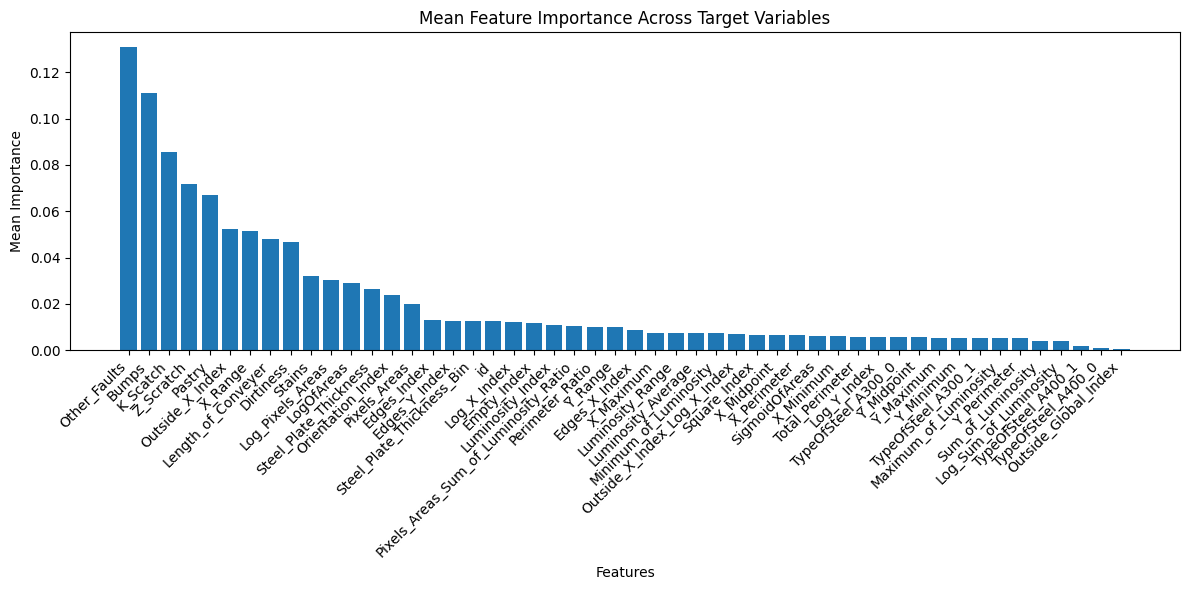


Top 10 features for Pastry:
Bumps: 0.1471
Length_of_Conveyer: 0.1457
Other_Faults: 0.1152
Dirtiness: 0.0841
Orientation_Index: 0.0771
K_Scatch: 0.0610
Z_Scratch: 0.0575
Edges_Y_Index: 0.0414
Empty_Index: 0.0165
Pixels_Areas_Sum_of_Luminosity_Ratio: 0.0147

Top 10 features for Bumps:
K_Scatch: 0.1844
Other_Faults: 0.1710
Z_Scratch: 0.1405
Pastry: 0.1285
Dirtiness: 0.0909
Stains: 0.0895
id: 0.0099
Luminosity_Index: 0.0082
Empty_Index: 0.0081
Pixels_Areas_Sum_of_Luminosity_Ratio: 0.0077

Top 10 features for Dirtiness:
Bumps: 0.0835
Z_Scratch: 0.0806
Pastry: 0.0697
Orientation_Index: 0.0598
K_Scatch: 0.0518
Other_Faults: 0.0473
Edges_Index: 0.0396
Steel_Plate_Thickness: 0.0364
Luminosity_Index: 0.0301
Length_of_Conveyer: 0.0279

Top 10 features for Stains:
Other_Faults: 0.1988
Log_Pixels_Areas: 0.1886
LogOfAreas: 0.1812
Pixels_Areas: 0.1174
Steel_Plate_Thickness: 0.0657
Bumps: 0.0507
SigmoidOfAreas: 0.0132
Length_of_Conveyer: 0.0111
Edges_Index: 0.0096
Y_Perimeter: 0.0092

Top 10 features

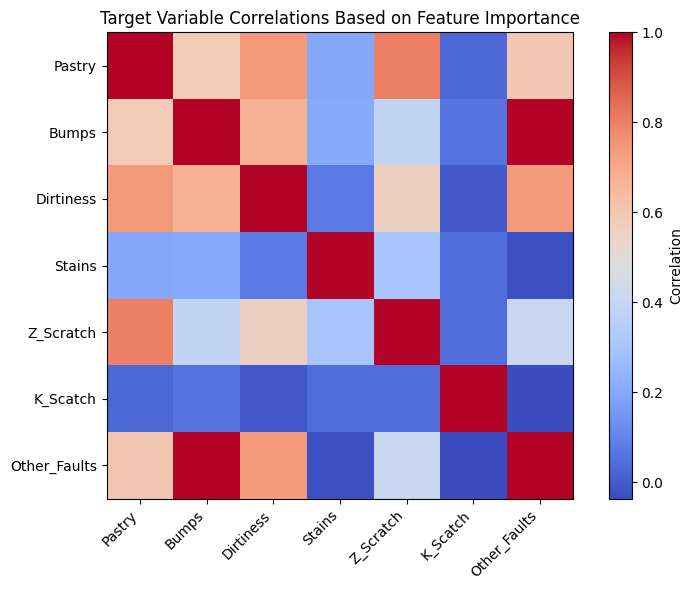

In [23]:
mean_importance = feature_importance_df.mean(axis=0)

sorted_features = mean_importance.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features.index, sorted_features.values)
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.title('Mean Feature Importance Across Target Variables')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identify the top 5 most important features for each target variable
top_features = {}
for target in feature_importance_df.index:
    top_features[target] = feature_importance_df.loc[target].nlargest(10)

# Print the top 5 most important features and their importance scores for each target variable
for target, features in top_features.items():
    print(f"\nTop 10 features for {target}:")
    for feature, importance in features.items():
        print(f"{feature}: {importance:.4f}")

# Calculate the pairwise correlations between target variables based on feature importance
target_correlations = feature_importance_df.T.corr()

# Plot a heatmap of the target variable correlations
plt.figure(figsize=(8, 6))
plt.imshow(target_correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(target_correlations.columns)), target_correlations.columns, rotation=45, ha='right')
plt.yticks(range(len(target_correlations.index)), target_correlations.index)
plt.title('Target Variable Correlations Based on Feature Importance')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [29]:
# # Specify the target variables in the refined order
# target_vars = ['K_Scatch', 'Stains', 'Other_Faults', 'Bumps', 'Z_Scratch', 'Pastry', 'Dirtiness']

# # Separate the features and target variables
# features = data.drop(columns=target_vars)
# target = data[target_vars]

# # Define the top features for each target variable based on feature importance
# top_features = {
#     'K_Scatch': ['Outside_X_Index', 'X_Range', 'Other_Faults', 'Log_X_Index', 'Steel_Plate_Thickness'],
#     'Stains': ['Other_Faults', 'Log_Pixels_Areas', 'LogOfAreas', 'Pixels_Areas', 'Steel_Plate_Thickness'],
#     'Other_Faults': ['K_Scatch', 'Bumps', 'Z_Scratch', 'Pastry', 'Stains', 'Dirtiness'],
#     'Bumps': ['K_Scatch', 'Other_Faults', 'Z_Scratch', 'Pastry', 'Dirtiness'],
#     'Z_Scratch': ['Bumps', 'Other_Faults', 'Length_of_Conveyer', 'Steel_Plate_Thickness_Bin', 'Pastry'],
#     'Pastry': ['Bumps', 'Length_of_Conveyer', 'Other_Faults', 'Dirtiness', 'Orientation_Index'],
#     'Dirtiness': ['Bumps', 'Z_Scratch', 'Pastry', 'Orientation_Index', 'K_Scatch']
# }

# Specify the target variables in the refined order
target_vars = ['K_Scatch', 'Stains', 'Z_Scratch', 'Pastry', 'Dirtiness', 'Bumps', 'Other_Faults']

# Separate the features and target variables
features = data.drop(columns=target_vars)
target = data[target_vars]

# Define the top features for each target variable based on feature importance
top_features = {
    'K_Scatch': ['Outside_X_Index', 'X_Range', 'Log_X_Index', 'Steel_Plate_Thickness', 'Outside_X_Index_Log_X_Index'],
    'Stains': ['Log_Pixels_Areas', 'LogOfAreas', 'Pixels_Areas', 'Steel_Plate_Thickness', 'SigmoidOfAreas'],
    'Z_Scratch': ['Length_of_Conveyer', 'Steel_Plate_Thickness_Bin', 'Steel_Plate_Thickness', 'TypeOfSteel_A300_0', 'TypeOfSteel_A300_1', 'Bumps', 'Pastry'],
    'Pastry': ['Length_of_Conveyer', 'Orientation_Index', 'Edges_Y_Index', 'Empty_Index', 'Pixels_Areas_Sum_of_Luminosity_Ratio', 'Bumps', 'Dirtiness', 'K_Scatch', 'Z_Scratch', 'Other_Faults'],
    'Dirtiness': ['Orientation_Index', 'Edges_Index', 'Steel_Plate_Thickness', 'Luminosity_Index', 'Length_of_Conveyer', 'Bumps', 'Z_Scratch', 'Pastry', 'K_Scatch', 'Other_Faults'],
    'Bumps': ['Luminosity_Index', 'Empty_Index', 'Pixels_Areas_Sum_of_Luminosity_Ratio', 'K_Scatch', 'Z_Scratch', 'Pastry', 'Dirtiness', 'Stains', 'Other_Faults'],
    'Other_Faults': ['Empty_Index', 'Pixels_Areas_Sum_of_Luminosity_Ratio', 'Edges_Index', 'K_Scatch', 'Bumps', 'Z_Scratch', 'Pastry', 'Stains', 'Dirtiness']
}

In [30]:
# Perform feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)


In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features_df, target, test_size=0.2, random_state=42)

# Train models sequentially based on the refined order
rf_models = {}
train_predictions = pd.DataFrame()
test_predictions = pd.DataFrame()

for target_var in target_vars:
    # Select the top features for the current target variable
    selected_features = top_features[target_var]
    
    # Add previous target variable predictions as features
    train_features = X_train.copy()
    test_features = X_test.copy()
    
    for feature in selected_features:
        if feature in train_predictions.columns:
            train_features[feature] = train_predictions[feature]
            test_features[feature] = test_predictions[feature]
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(train_features, y_train[target_var])
    rf_models[target_var] = rf_model
    
    # Make predictions and add them to the predictions DataFrames
    train_predictions[target_var] = rf_model.predict(train_features)
    test_predictions[target_var] = rf_model.predict(test_features)

In [32]:
# Evaluate the model's performance using average AUC
auc_scores = []
for target_var in target_vars:
    auc = roc_auc_score(y_test[target_var], test_predictions[target_var])
    auc_scores.append(auc)
    print(f"AUC for {target_var}: {auc:.4f}")

print(f"\nAverage AUC: {np.mean(auc_scores):.4f}")

AUC for K_Scatch: 0.9831
AUC for Stains: 0.9830
AUC for Z_Scratch: 0.9314
AUC for Pastry: 0.8458
AUC for Dirtiness: 0.8340
AUC for Bumps: 0.7945
AUC for Other_Faults: 0.6894

Average AUC: 0.8659


In [33]:
# Load the test dataset
test_data = pd.read_csv('data/test.csv')

test_data = gen_features(test_data)


# Select the same features as in the training data
test_features = test_data[features.columns]

# Perform feature scaling on the test data
scaled_test_features = scaler.transform(test_features)
scaled_test_features_df = pd.DataFrame(scaled_test_features, columns=test_features.columns)

# Make predictions on the test data
test_predictions = pd.DataFrame()

for target_var in target_vars:
    # Select the top features for the current target variable
    selected_features = top_features[target_var]
    
    # Add previous target variable predictions as features
    test_features = scaled_test_features_df.copy()
    
    for feature in selected_features:
        if feature in test_predictions.columns:
            test_features[feature] = test_predictions[feature]
    
    test_predictions[target_var] = rf_models[target_var].predict(test_features)

# Combine the test predictions with the 'id' column
output_data = pd.concat([test_data['id'], test_predictions], axis=1)

# Save the output data to 'output.csv'
output_data.to_csv('output.csv', index=False)